In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor

### Data description

In [2]:
df_metadata = pd.read_csv('ebu3b/data/ebu3b_metadata.csv')
print "Number of unique signals = ", df_metadata['Ground Truth Point Type'].nunique()
print "Number of unique rooms = ", df_metadata['Location'].nunique()

Number of unique signals =  229
Number of unique rooms =  253


#### BACnet types

- BACnet: Building Automation and Control Network
- 8 different types of BACnet types
- Majority of them are Analog Input and analog Output

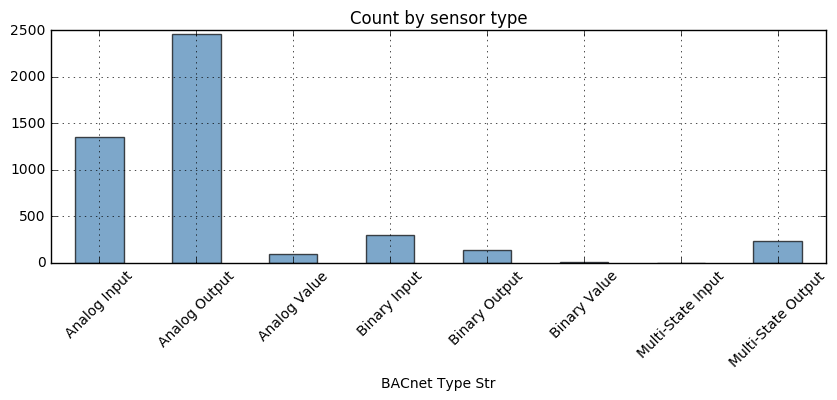

In [3]:
df_metadata.groupby('BACnet Type Str')['BACnet Type Str'].count().plot(
    kind='bar', grid=True, alpha=0.7, color='steelblue', figsize=(10, 3), rot=45,
    title='Count by sensor type');

#### Signal count for each building

- Almost all the data is in EBU3B building

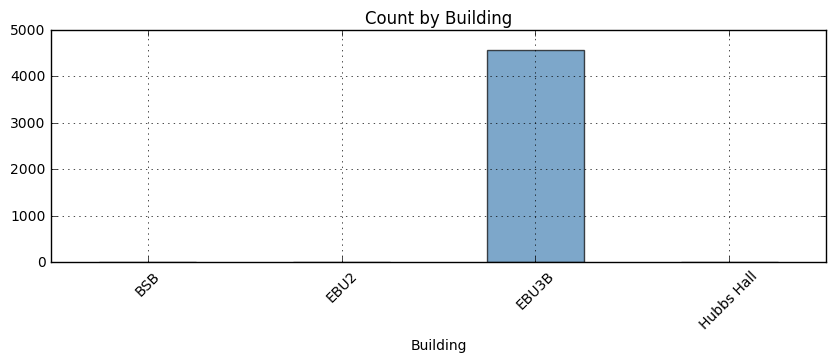

In [4]:
df_metadata.groupby('Building')['Building'].count().plot(
    kind='bar', grid=True, alpha=0.7, color='steelblue', figsize=(10, 3), rot=45,
    title='Count by Building');

#### Signal distribution based on room

- Room B102C and server room have highest number of signals

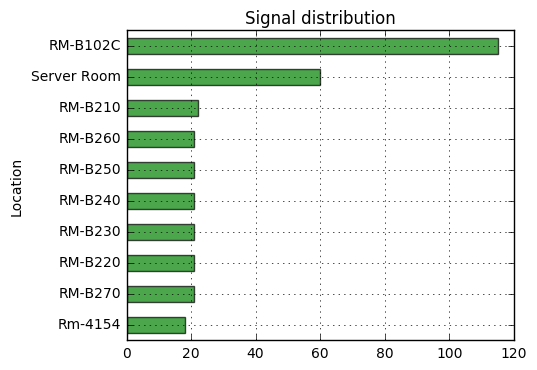

In [5]:
top10_df = df_metadata.groupby(['Location'])['Ground Truth Point Type'].nunique().sort_values(ascending=False).head(10)
top10_df.sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.7, grid=True, figsize=(5, 4),
                                                   legend=False, title='Signal distribution');

### Weather data

- Weather data for La Jolla is purchased from https://openweathermap.org/
![weather description](weather_metadata.png)

#### Weather data cleanup

- Remove columns that have all / most nans
- Remove columns that are not applicable (city_id, weather_icon)

- columns that are retained are:


1) dt_iso  
2) temp  
3) temp_min  
4) temp_max  
5) pressure  
6) humidity  
7) wind_speed  
8) wind_deg  
9) clouds_all  
10) weather_id  
11) weather_main

#### Feature engineering

1) Conversion of temperature columns from Klevin to farenhrit  
2) Label encoding for weather_main

In [6]:
# Columns required from weather data
req_columns = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
               'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'weather_main']
# Read the weather data frame
weather_df = pd.read_csv('ebu3b/weather.csv')[req_columns]

# Remove UTC and convert to datetime
weather_df['dt_iso'] = pd.to_datetime(weather_df.dt_iso.str.replace(" UTC", ""))
# Convert to pacific standard time.
weather_df = weather_df.set_index('dt_iso').tz_localize('UTC').tz_convert('US/Pacific').reset_index()

# Strip time zone info and convert to datetime.
weather_df['dt_iso'] = pd.to_datetime(weather_df.dt_iso.astype('str').str.replace("-07:00", ""))

# Convert temperatures to farenheit
weather_df['temp'] = weather_df.temp * 9 / 5 - 459.67
weather_df['temp_min'] = weather_df.temp_min * 9 / 5 - 459.67
weather_df['temp_max'] = weather_df.temp_max * 9 / 5 - 459.67

# Encode the weather_main
weather_df['weather_main'] = LabelEncoder().fit_transform(weather_df.weather_main)

# Create datetime columns
weather_df['date'] = weather_df.dt_iso.dt.date
weather_df['hour'] = weather_df.dt_iso.dt.hour

weather_df.head(3)

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,date,hour
0,2012-10-01 06:00:00,65.318,62.006,75.992,1013,59,1,60,1,800,0,2012-10-01,6
1,2012-10-01 07:00:00,64.940,60.008,78.008,1013,55,0,0,3,721,4,2012-10-01,7
2,2012-10-02 08:00:00,69.422,60.800,82.004,1014,56,1,340,3,721,4,2012-10-02,8


In [7]:
data_path = "./ebu3b/data/"
def get_signal_dataframe(room, signals = None, hour_mean=True):
    df_list = []
    df_filtered = df_metadata[(df_metadata.Location == room)]
    if not signals is None:
        df_filtered = df_filtered[df_filtered['Ground Truth Point Type'].isin(signals)]

    for identifier in df_filtered['Unique Identifier'].values:
        # Filename is same as identifier
        filename = identifier + ".csv"
        
        # Read the csv 
        df = pd.read_csv(data_path + filename).dropna()
        
        # Convert to datetime object
        df["time"] = pd.to_datetime(df.time)

        if hour_mean:
            # Groupby to average the
            groupby_item = pd.to_datetime(df.time.dt.date) + pd.to_timedelta(df.time.dt.hour.astype("str") + " hours")
            df = df.groupby(groupby_item)[['value']].mean().reset_index()

        # Create new colunms
        df["identifier"], df['location'] = identifier, room

        # append the data frame to list
        df_list.append(df)
        
        print "Read file: ", filename

    df_all = pd.concat(df_list)

    # Merge the dataframe with meta data and filter hte required columns
    df_all = df_all.merge(df_metadata, right_on="Unique Identifier", left_on="identifier")[["time",
        "value", "identifier", "location", "Ground Truth Point Type"]]
    rm_signals = df_all.pivot_table(values='value', index=['time', 'location'], \
                                                  columns="Ground Truth Point Type").reset_index()
    return weather_df.merge(rm_signals, left_on='dt_iso', right_on='time')

In [8]:
room = 'Rm-3114'
signals= ["Zone Temperature"]
model_df = get_signal_dataframe(room, signals)
model_df.head()

Read file:  506_0_3003116.csv


,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,date,hour,time,location,Zone Temperature
0,2014-01-01 00:00:00,64.940,59.000,71.006,1029,71,0,225,56,803,1,2014-01-01,0,2014-01-01 00:00:00,Rm-3114,64.9025
1,2014-01-01 01:00:00,61.052,57.002,64.994,1029,71,0,261,56,803,1,2014-01-01,1,2014-01-01 01:00:00,Rm-3114,64.5900
2,2014-01-01 02:00:00,57.092,53.996,60.008,1030,71,2,281,56,701,5,2014-01-01,2,2014-01-01 02:00:00,Rm-3114,64.5900
3,2014-01-01 03:00:00,54.536,51.998,57.002,1030,71,1,351,56,741,3,2014-01-01,3,2014-01-01 03:00:00,Rm-3114,64.5900
4,2014-01-01 04:00:00,52.466,48.002,57.002,1030,71,0,13,56,701,5,2014-01-01,4,2014-01-01 04:00:00,Rm-3114,64.3400


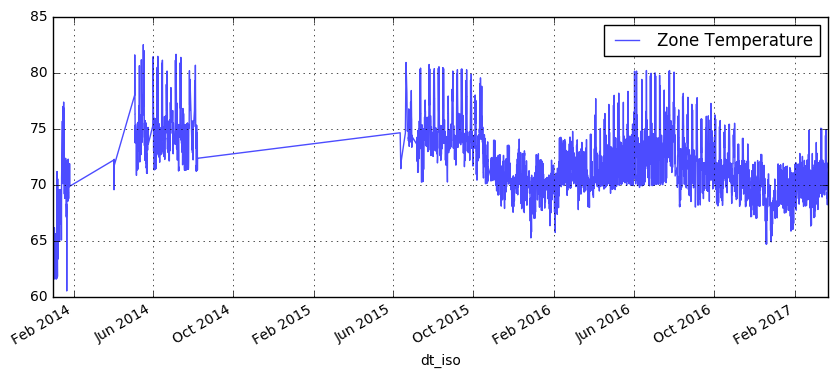

In [9]:
model_df.sort_values(by = 'dt_iso', ascending=True).set_index('dt_iso')[['Zone Temperature']].plot(
    grid=True, figsize=(10, 4), alpha=0.7);

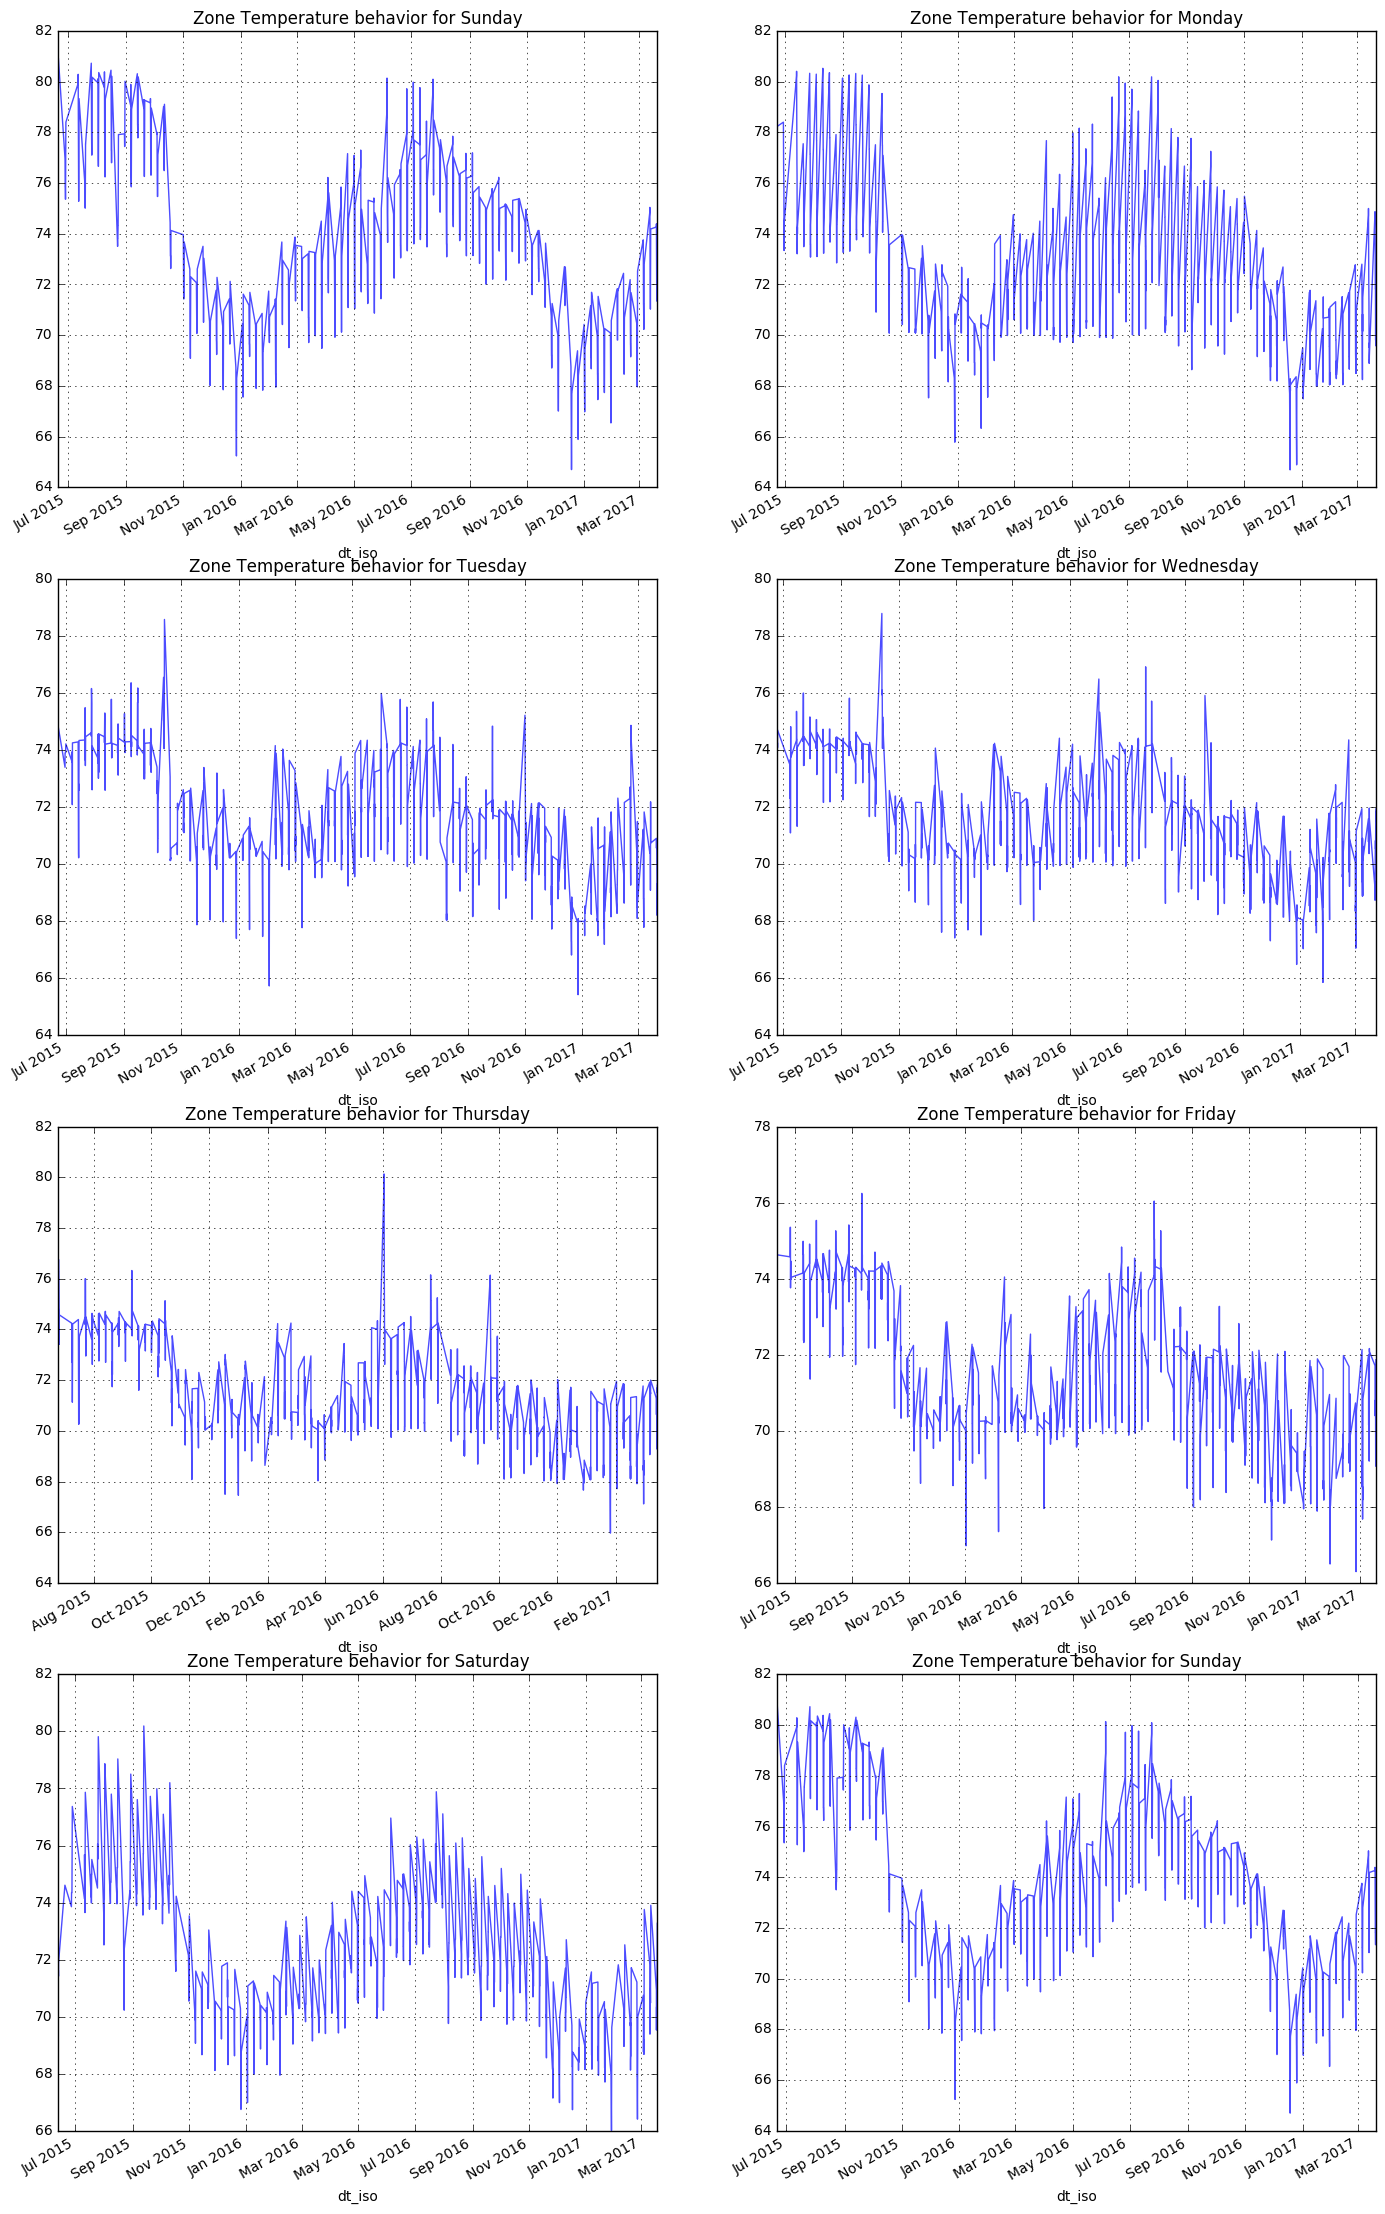

In [10]:
# Filter the data from june 2015
model_filtered = model_df[model_df.dt_iso > pd.to_datetime("2015-06-01")]

fig, axs = plt.subplots(4, 2, figsize=(17, 30))

def plot_graph(model_filtered, ax, day, signal):
    model_filtered[model_filtered.dt_iso.dt.weekday_name == day].set_index('dt_iso')[['Zone Temperature']].plot(
        grid=True, alpha=0.7, ax=ax, legend=False)
    ax.set_title(signal + " behavior for " + day)

plot_graph(model_filtered, axs[0][0], "Sunday", "Zone Temperature")
plot_graph(model_filtered, axs[0][1], "Monday", "Zone Temperature")
plot_graph(model_filtered, axs[1][0], "Tuesday", "Zone Temperature")
plot_graph(model_filtered, axs[1][1], "Wednesday", "Zone Temperature")
plot_graph(model_filtered, axs[2][0], "Thursday", "Zone Temperature")
plot_graph(model_filtered, axs[2][1], "Friday", "Zone Temperature")
plot_graph(model_filtered, axs[3][0], "Saturday", "Zone Temperature")
plot_graph(model_filtered, axs[3][1], "Sunday", "Zone Temperature")

In [11]:
def model_for_day(model_df, features, target, day='Sunday'):
    model_df = model_df.dropna()
    X = model_df[model_df.dt_iso.dt.weekday_name == day][features]
    y = model_df[model_df.dt_iso.dt.weekday_name == day][target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

    list_df = []
    reg = DecisionTreeRegressor().fit(X_train, y_train)
    list_df.append(pd.DataFrame({'model' : 'DecisionTreeRegressor', 'train score' : reg.score(X_train, y_train),
                  'test score' : reg.score(X_test, y_test)}, index=[0]))

    reg = LinearRegression().fit(X_train, y_train)
    list_df.append(pd.DataFrame({'model' : 'LinearRegression', 'train score' : reg.score(X_train, y_train),
                  'test score' : reg.score(X_test, y_test)}, index=[0]))

    reg = Lasso().fit(X_train, y_train)
    list_df.append(pd.DataFrame({'model' : 'Lasso', 'train score' : reg.score(X_train, y_train),
                  'test score' : reg.score(X_test, y_test)}, index=[0]))

    reg = Ridge().fit(X_train, y_train)
    list_df.append(pd.DataFrame({'model' : 'Ridge', 'train score' : reg.score(X_train, y_train),
                  'test score' : reg.score(X_test, y_test)}, index=[0]))

    reg = AdaBoostRegressor().fit(X_train, y_train)
    list_df.append(pd.DataFrame({'model' : 'AdaBoostRegressor', 'train score' : reg.score(X_train, y_train),
                  'test score' : reg.score(X_test, y_test)}, index=[0]))

    return pd.concat(list_df, ignore_index=True)

room = 'Rm-3114'
signals = ["Zone Temperature", 'Supply Airflow']
features = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
        'clouds_all', 'weather_id', 'weather_main', 'hour']
day = "Sunday"
target = "Zone Temperature"

model_df = get_signal_dataframe(room, signals)
model_for_day(model_df, features, target)

Read file:  506_0_3003116.csv
Read file:  506_0_3003122.csv


,model,test score,train score
0,DecisionTreeRegressor,0.743859,1.000000
1,LinearRegression,0.703811,0.691586
2,Lasso,0.703173,0.684132
3,Ridge,0.703820,0.691586
4,AdaBoostRegressor,0.762715,0.777978


In [12]:
room = 'Rm-3114'
signals = ["Zone Temperature", 'Supply Airflow']
features = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
        'clouds_all', 'weather_id', 'weather_main', 'hour', "Zone Temperature"]
day = "Sunday"
target = 'Supply Airflow'

model_df = get_signal_dataframe(room, signals)
model_for_day(model_df, features, target)

Read file:  506_0_3003116.csv
Read file:  506_0_3003122.csv


,model,test score,train score
0,DecisionTreeRegressor,0.459924,1.000000
1,LinearRegression,0.112775,0.132351
2,Lasso,0.114778,0.131168
3,Ridge,0.112779,0.132351
4,AdaBoostRegressor,0.514900,0.733803
